# Sleeping Pattern Analysis

The aim of this notebook is to do an exploratory data analysis of the sleeping data I have collected over the past two years.
I have taken the data from my watch Amazfit Bip using the "Mi FIT" app (Xiaomi watch). I found a way of exporting data in the CSV format.

The file exported is called: "export.csv"

#### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### sneak peek at the data

In [2]:
df = pd.read_csv("export.csv")
df.head(3)

,Start sleep,Start sleep.1,End sleep,End sleep.1,Sleep type,Sleep minutes
0,1.514250e+12,26/12/2017 01:39:00,1.514260e+12,26/12/2017 02:58:00,Light sleep,79
1,1.514260e+12,26/12/2017 02:58:00,1.514260e+12,26/12/2017 03:02:00,Deep sleep,4
2,1.514260e+12,26/12/2017 03:02:00,1.514260e+12,26/12/2017 03:27:00,Light sleep,25


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7447 entries, 0 to 7446
Data columns (total 6 columns):
Start sleep      7447 non-null float64
Start sleep.1    7447 non-null object
End sleep        7447 non-null float64
End sleep.1      7447 non-null object
Sleep type       7447 non-null object
Sleep minutes    7447 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 349.2+ KB


There are 6 columns in the dataset and 7447 entries.
the columns indicate the following:

1) **"Start sleep"**: start of the sleeping cycle as the number of seconds that have elapsed since 1 January 1970 (Unix epoch convention) - note: there might be more sleeping cycles during the same night

2) **"Start sleep.1"**: as above but converted as actual date (it is still an "object", so I need to convert it as a datetime object)

3) **"End sleep"**: end of the sleeping cycle as the number of seconds that have elapsed since 1 January 1970 (Unix epoch convention)

4) **"End sleep.1"**: as above but converted as "date"

5) **Sleep type**: indicates the type of sleep: 3 options: 'Deep sleep', 'light sleep', 'Awake'

6) **Sleep minutes**: self-explanatory; it is the difference between "End sleep" and "start sleep" in minutes

Basically "Start sleep" and "Start sleep.1" and "End sleep" and "End sleep.1" have redundant information.
I'm going to drop the columns "Start sleep" and "End sleep"

In [4]:
df.drop(columns = ["Start sleep", "End sleep"], inplace= True)

The columns "Start sleep.1" and "End sleep.1" are still "object" type. I want to convert them as "datetime" object.

Also, I'm going to rename them as "Start" and "End"

In [5]:
df[["Start sleep.1", "End sleep.1"]] = df[["Start sleep.1", "End sleep.1"]].apply(pd.to_datetime)

In [6]:
df.rename(columns={"Start sleep.1": "Start", "End sleep.1": "End"}, inplace = True )

In [7]:
df.info()
# we can see that the columns have been renamed as "Start" and "End" and the type is "datetime64[ns]"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7447 entries, 0 to 7446
Data columns (total 4 columns):
Start            7447 non-null datetime64[ns]
End              7447 non-null datetime64[ns]
Sleep type       7447 non-null object
Sleep minutes    7447 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 232.8+ KB


In [8]:
df.head()

,Start,End,Sleep type,Sleep minutes
0,2017-12-26 01:39:00,2017-12-26 02:58:00,Light sleep,79
1,2017-12-26 02:58:00,2017-12-26 03:02:00,Deep sleep,4
2,2017-12-26 03:02:00,2017-12-26 03:27:00,Light sleep,25
3,2017-12-26 03:27:00,2017-12-26 03:33:00,Deep sleep,6
4,2017-12-26 03:33:00,2017-12-26 04:25:00,Light sleep,52


I'm going to create a new column, to be used as index, that represents each day of sleep, called "Date"

In [9]:
df['Date'] = df['End'].dt.strftime('%d-%m-%Y').apply(pd.to_datetime)
df.set_index("Date", inplace= True)
df.head(3)

,Start,End,Sleep type,Sleep minutes
Date,,,,
2017-12-26,2017-12-26 01:39:00,2017-12-26 02:58:00,Light sleep,79
2017-12-26,2017-12-26 02:58:00,2017-12-26 03:02:00,Deep sleep,4
2017-12-26,2017-12-26 03:02:00,2017-12-26 03:27:00,Light sleep,25


I prefer having the total amount of sleep in hours instead of minutes.

I'll create a new column "Sleep hours" and I'll drop the "Sleep minutes" column

In [10]:
df["Sleep hours"] = (df["Sleep minutes"]/ 60).round(2) # keep the first two decimals
df.drop("Sleep minutes", inplace = True, axis = 1)

In [11]:
# check the new column "Sleep hours" have been added and "Sleep minutes" have been dropped from the dataframe
df.head(2)

,Start,End,Sleep type,Sleep hours
Date,,,,
2017-12-26,2017-12-26 01:39:00,2017-12-26 02:58:00,Light sleep,1.32
2017-12-26,2017-12-26 02:58:00,2017-12-26 03:02:00,Deep sleep,0.07


Let's rearrange the data using the pivot_table method

In [12]:
sleep = df.pivot_table(values= "Sleep hours",index='Date', columns='Sleep type', aggfunc='sum', fill_value= 0)

Create a new column with the total amount of hours slept during the night (Deep + light sleep)

In [13]:
sleep["Total sleep"] = sleep["Deep sleep"] + sleep['Light sleep']
sleep.head()

Sleep type,Awake,Deep sleep,Light sleep,Total sleep
Date,,,,
2017-12-26,0.00,1.49,5.38,6.87
2017-12-27,0.35,1.51,5.18,6.69
2017-12-28,0.31,1.35,6.94,8.29
2017-12-29,0.25,1.08,6.90,7.98
2017-12-31,0.13,4.57,6.67,11.24


### Check for "outliers"

In [14]:
sleep.describe()

Sleep type,Awake,Deep sleep,Light sleep,Total sleep
count,513.000000,513.000000,513.000000,513.000000
mean,0.140234,1.685770,5.731072,7.416842
std,0.172544,0.786652,3.731095,3.782049
min,0.000000,0.000000,0.170000,0.180000
25%,0.000000,1.120000,4.720000,6.560000
50%,0.080000,1.700000,5.810000,7.700000
75%,0.200000,2.200000,6.670000,8.320000
max,1.160000,4.570000,79.420000,79.420000


We can immediately spot something weird; the max amount of light sleep is 79.42 hours; it is over 3 days of consecutive sleep (I wish)...
let's check if there are other anomalous values.

I'm going to check the 10 days with the highest total sleep time and lowest sleep time and see if there is something unusual.

Let's start with the 10 "highest amount of sleeping hours"

In [15]:
sleep['Total sleep'].sort_values(ascending=False).head(10)

Date
2018-04-23    79.42
2018-09-20    22.28
2018-04-26    14.11
2018-03-16    12.48
2019-09-07    11.57
2017-12-31    11.24
2019-03-02    11.02
2018-04-07    11.01
2019-01-20    10.93
2018-05-26    10.92
Name: Total sleep, dtype: float64

Ok, 79.42 and 22.28 hours seems unrealistic (I'm going to drop these two entries); 14.11 hours is borderline but I'll keep this data point.

Let's check  the 10 "lowest amount of sleeping hours"

In [16]:
sleep['Total sleep'].sort_values(ascending=True).head(10)

Date
2019-06-23    0.18
2018-09-18    0.24
2019-07-08    0.28
2018-10-08    0.29
2018-01-24    0.76
2018-04-30    0.77
2019-01-03    0.98
2018-03-15    1.08
2019-04-13    1.10
2019-06-17    1.22
Name: Total sleep, dtype: float64

Less then 2 hours of sleep seems unrealistic; I'm going to drop all rows with total sleep time less than 2 hours.

So all in all, Im going to keep the data where the total sleep time is between 2 and 15 hours

In [17]:
sleep =  sleep.loc[(sleep['Total sleep'] > 2) & (sleep['Total sleep'] < 15)]

In [18]:
sleep.describe()

Sleep type,Awake,Deep sleep,Light sleep,Total sleep
count,497.000000,497.000000,497.000000,497.000000
mean,0.143722,1.734728,5.689074,7.423803
std,0.173811,0.748678,1.472883,1.638225
min,0.000000,0.000000,1.150000,2.150000
25%,0.020000,1.170000,4.830000,6.690000
50%,0.080000,1.700000,5.920000,7.740000
75%,0.210000,2.220000,6.700000,8.330000
max,1.160000,4.570000,12.100000,14.110000


From table above I can see that my **average total sleep time** is around **7.42 hours** (~1.7 hours of deep sleep and ~5.7 hours of light sleep).

Also I notice that my sleeping pattern is quite erratic, the **standard deviation is ~1.63 hours**, Ideally this value should be below 1hour (at least)

## Data Visualization
now that we have the data in a "clean" format we can visualize them

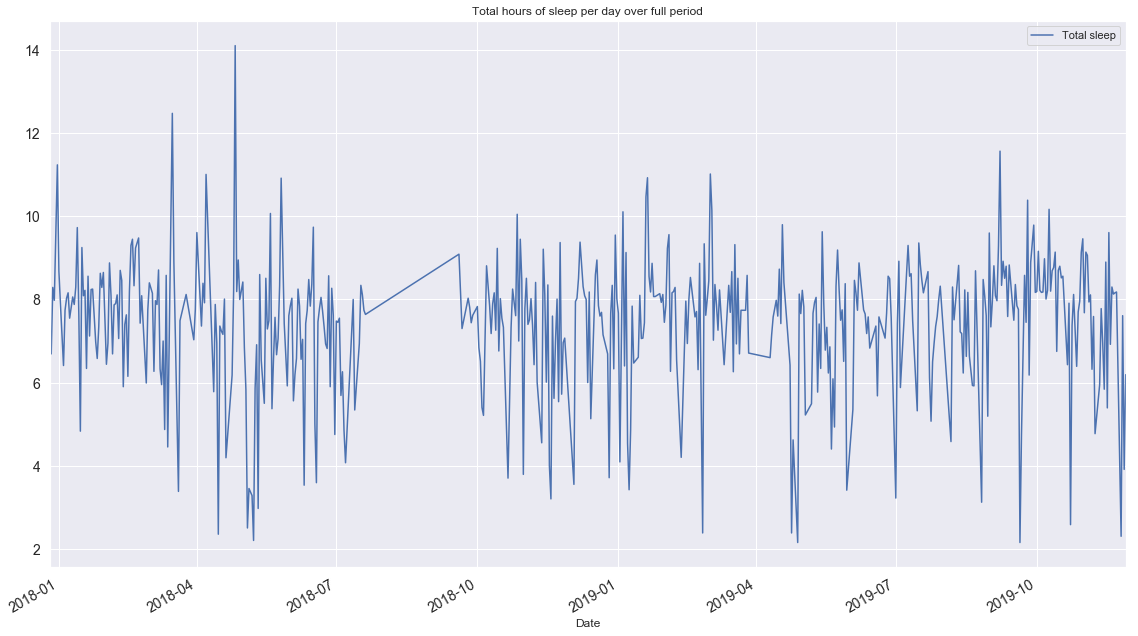

In [30]:
sns.set()
sleep.plot(y = "Total sleep", figsize = (16,9), grid = True,
           title = "Total hours of sleep per day over full period", fontsize=14)
plt.tight_layout()

I noticed one thing immediately: it appears to be missing data during summer 2017 (period Aug-Sep) and during April 2019.

this is because the data in the graph seems to be interpolated.

This becomes clear (data goes to zero) if we find the count of hours slept *per week* with the resample method

Text(0.5, 1.0, 'Hours slept per Week (Showing Missing Data)')

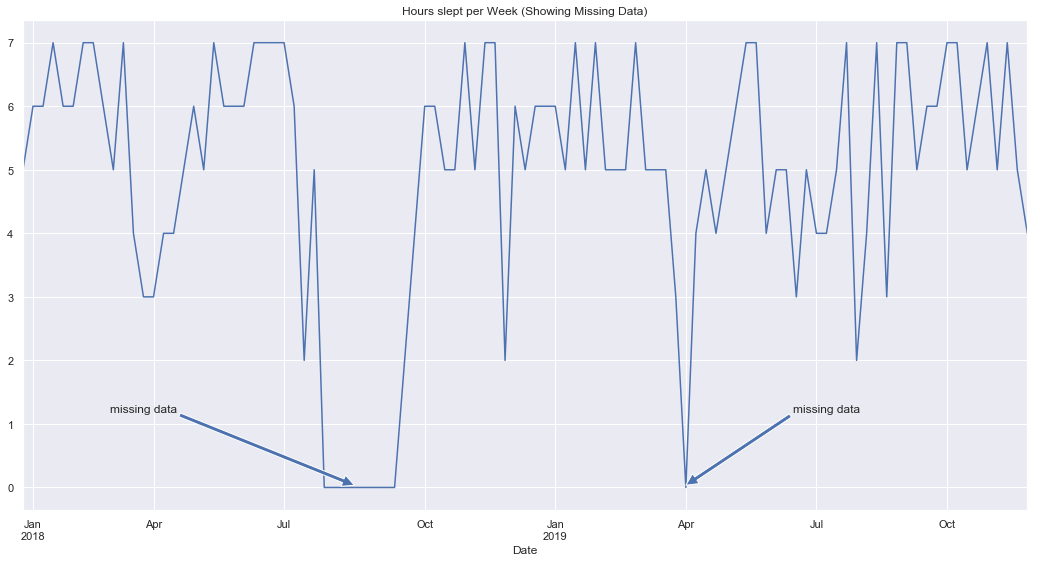

In [32]:
by_week = sleep.resample('W').size()
ax = by_week.plot(figsize=(18,9), title='Hours slept per Week', grid=True)
ax.annotate(xy=(.33, .05), xytext=(.12, .2), xycoords='axes fraction', s='missing data',ha='center', size=12, arrowprops=dict())
ax.annotate(xy=(.66, .05), xytext=(.8, .2), xycoords='axes fraction', s='missing data',ha='center', size=12, arrowprops=dict())
ax.set_title('Hours slept per Week (Showing Missing Data)')

the graph goes to zero in Aug-Sep 2018 and end Mar- beginning Apr 2019

I did not wear my watch during these periods. In sep 2018 I was for 3 weeks in Srilanka, so it makes sense I have no data (I didnt bring my watch); End of March 2019 - beginning of Apr 2019 I was on holiday again

Let's check the months when I slept the most

In [33]:
sleep_by_month = sleep.copy()

In [34]:
sleep_by_month.index = sleep_by_month.index.month_name()

In [35]:
sleep_by_month = sleep_by_month.pivot_table(index='Date',  aggfunc='mean', fill_value= 0).sort_values(by = "Total sleep")

In [36]:
sleep_by_month

Sleep type,Awake,Deep sleep,Light sleep,Total sleep
Date,,,,
May,0.168333,1.649444,5.111296,6.760741
November,0.107959,1.595918,5.435102,7.031020
August,0.140500,1.975000,5.132000,7.107000
July,0.143333,1.424444,5.786111,7.210556
June,0.155000,1.618125,5.640417,7.258542
April,0.134571,1.743143,5.614000,7.357143
December,0.186207,2.008276,5.589310,7.597586
January,0.127170,1.688491,5.991132,7.679623
March,0.156750,1.842000,5.850250,7.692250


Text(0.5, 1.0, 'Total sleeping hours by month')

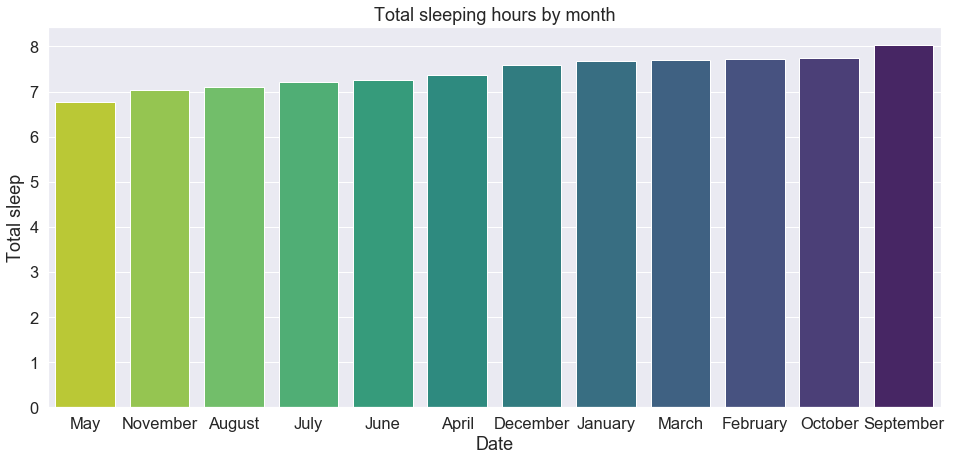

In [47]:
sns.set_context("notebook", font_scale=1.5)
plt.rcParams['figure.figsize'] = (16, 7)
sns.barplot(x = sleep_by_month.index, y = "Total sleep", data = sleep_by_month, palette = "viridis_r").set_title('Total sleeping hours by month')

From the graph above, September is the month when I sleep the most, May is on the opposite spectrum.
I can't find a specific reason why is that..

let's check  by day of the week, maybe there is a clear pattern between weekdays and weekends..

In [38]:
sleep.index= sleep.index.day_name()

In [39]:
sleep_by_day = sleep.pivot_table(index='Date',  aggfunc='mean', fill_value= 0).sort_values(by = "Total sleep")

In [40]:
sleep_by_day

Sleep type,Awake,Deep sleep,Light sleep,Total sleep
Date,,,,
Monday,0.135942,1.433333,5.404203,6.837536
Wednesday,0.107901,1.869506,5.445926,7.315432
Friday,0.155823,1.659494,5.680506,7.340000
Sunday,0.163846,1.766731,5.725385,7.492115
Tuesday,0.129878,1.713049,5.807683,7.520732
Thursday,0.132530,1.842169,5.752771,7.594940
Saturday,0.212353,1.872353,6.142549,8.014902


Text(0.5, 1.0, 'Total sleeping hours by day of the week')

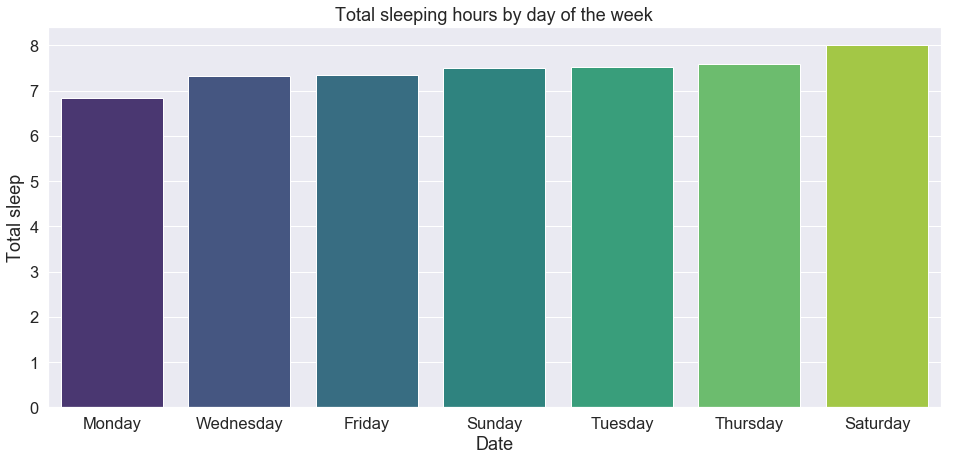

In [46]:
sns.barplot(x = sleep_by_day.index, y = "Total sleep", data = sleep_by_day, palette = "viridis").set_title('Total sleeping hours by day of the week')

It makes sense for me to sleep more during Saturdays and less during Mondays, this is because since I tend to go to sleep later during weekends, falling asleep on Mondays evening becomes more challenging